# In this notebook, i will predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv('student_data.csv')

data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

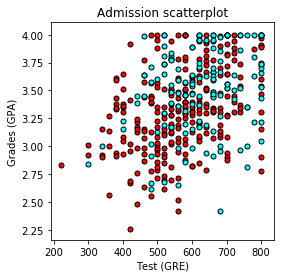

In [6]:
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.figure(figsize = (4,4))
    plt.title("Admission scatterplot")
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    

plot_points(data)
#plt.show()

## Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

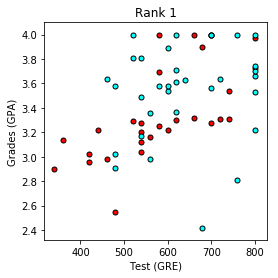

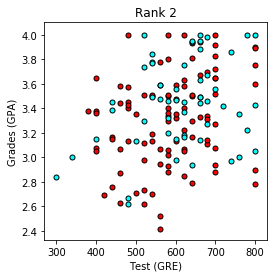

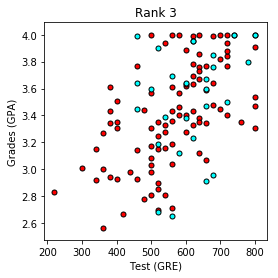

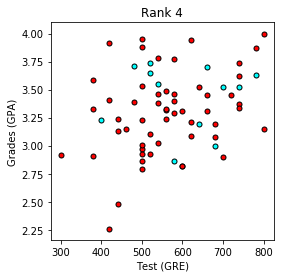

In [8]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

plot_points(data_rank1)
plt.title("Rank 1")
plt.show()

plot_points(data_rank2)
plt.title("Rank 2")
plt.show()

plot_points(data_rank3)
plt.title("Rank 3")
plt.show()

plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

## This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.


In [17]:
one_hot_data = pd.get_dummies(data=data, drop_first=True, columns = ['rank'])
one_hot_data.head()

,admit,gre,gpa,rank_2,rank_3,rank_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


## Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [25]:
scaler = MinMaxScaler()
one_hot_data.iloc[:,1:3] = scaler.fit_transform(one_hot_data.iloc[:,1:3].values)

one_hot_data.head()

,admit,gre,gpa,rank_2,rank_3,rank_4
0,0,0.275862,0.775862,0,1,0
1,1,0.758621,0.810345,0,1,0
2,1,1.000000,1.000000,0,0,0
3,1,0.724138,0.534483,0,0,1
4,0,0.517241,0.385057,0,0,1


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [33]:
X,Y = one_hot_data.iloc[:,1:].values, one_hot_data.admit.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

print("Number of training samples is", len(X_train))
print("Number of testing samples is", len(X_test))
print(X_train[:10])
print("\n")
print(X_test[:10])

Number of training samples is 360
Number of testing samples is 40
[[0.72413793 0.7183908  1.         0.         0.        ]
 [0.82758621 0.74712644 1.         0.         0.        ]
 [0.4137931  0.4137931  0.         0.         0.        ]
 [0.82758621 0.58045977 1.         0.         0.        ]
 [0.44827586 0.83333333 0.         0.         1.        ]
 [0.62068966 0.45977011 1.         0.         0.        ]
 [1.         0.72988506 0.         0.         0.        ]
 [0.55172414 0.7183908  1.         0.         0.        ]
 [0.44827586 0.5        1.         0.         0.        ]
 [0.72413793 0.8908046  1.         0.         0.        ]]


[[0.72413793 0.3908046  1.         0.         0.        ]
 [0.4137931  0.99425287 0.         1.         0.        ]
 [0.72413793 0.72413793 0.         0.         1.        ]
 [0.55172414 0.53448276 1.         0.         0.        ]
 [0.55172414 0.51724138 0.         1.         0.        ]
 [0.48275862 0.97126437 0.         0.         1.        ]
 [0

## Training the 2-layer Neural Network
The following function trains the 2-layer neural network. First, we'll write some helper functions.

In [42]:
# model utils
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))

def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

def error_term_formula(y, output):
    return (y - output) * output * (1 - output)

In [43]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.5

def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error, the target minus the network output
            error = error_formula(y, output)

            # The error term
            error_term = error_term_formula(y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * x

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(X_train, Y_train, epochs, learnrate)

Epoch: 0
Train loss:  0.30001369990335
Epoch: 100
Train loss:  0.2200271677083272
Epoch: 200
Train loss:  0.21340471410059894
Epoch: 300
Train loss:  0.20908170804438256
Epoch: 400
Train loss:  0.20593847912688096
Epoch: 500
Train loss:  0.20362830681060204
Epoch: 600
Train loss:  0.20193082326827536
Epoch: 700
Train loss:  0.20068152912169354
Epoch: 800
Train loss:  0.19975808773133788
Epoch: 900
Train loss:  0.19907134883658115
Finished training!


## Calculating the Accuracy on the Test Data

In [45]:
test_out = sigmoid(np.dot(X_test, weights))
predictions = test_out > 0.5
accuracy = np.mean(predictions == Y_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.625
